In [1]:
%matplotlib inline

import itertools
import operator
import re
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import jieba
import tensorflow as tf
import zhon.hanzi as zh

### 1. 数据清理

In [2]:
def read_data(filename):
    """Read and cut sequences, return a long string."""
    jieba.setLogLevel(20)
    jieba.enable_parallel(4)
    with open(filename, 'r') as file:
        data = file.read()
    # Split sequences with zh.punctuation or 'new line'
    sequences = re.split(r'[{}|\n]'.format(zh.punctuation), data)
    # Remove empty string
    sequences = (sequence for sequence in sequences if sequence)
    sequences = (list(jieba.cut(sequence)) for sequence in sequences)
    return sequences

In [3]:
def get_common_words(words, n):
    count = Counter(words)
    count_dict = {i: j for i, j in count.items() if j > n}
    word_counts = sorted(count_dict.items(), key=operator.itemgetter(1), reverse=True)
    return word_counts

In [4]:
def build_dict(word_counts):
    count = [['UNK', -1]]
    count.extend(word_counts)
    word_dict = {key: value for value, (key, _) in enumerate(count)}
    reversed_dict = {key: value for value, key in word_dict.items()}
    return word_dict, reversed_dict

In [5]:
def word_to_number(sequences, word_dict):
    data = []
    for sequence in sequences:
        sequence_data = []
        for word in sequence:
            if word in word_dict:
                index = word_dict[word]
            else:
                index = 0
            sequence_data.append(index)
        data.append(sequence_data)
    return data

In [6]:
data = list(read_data('YGZ-rain.md'))

In [7]:
words = list(itertools.chain.from_iterable(data))

In [8]:
word_counts = get_common_words(words, 0)  # 小语料训练，所以不做截断了

In [9]:
word_dict, reversed_dict = build_dict(word_counts)

In [10]:
text_data = word_to_number(data, word_dict)

### 0. 定义参数

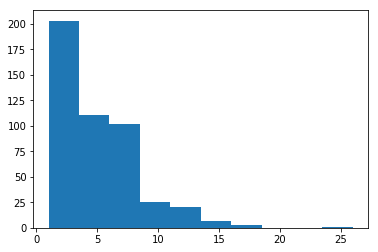

In [11]:
length = [len(i) for i in text_data]
plt.hist(length)
plt.show()

大部分句子长度都在10以下

In [12]:
vocab_size = len(word_counts) + 1  # 1214
hidden_size = 128  # The same as embedding dim
batch_size = 20
max_words = 10
number_steps = max_words - 1
epochs = 1000 + 1
print_loss_every = 100
lr = 0.001

### 1. 定义测试数据

In [13]:
data_padding = np.asarray([x[:max_words] for x in [y + [0] * max_words 
                                         for y in text_data]])

In [14]:
x = data_padding[:, :number_steps]
y_ = data_padding[:, 1:]

In [15]:
train_data = np.concatenate((x, y_), axis=1)  # 方便 shuffle

### 2. 定义神经网络结构以及前向传播过程

In [16]:
# Placeholder for input, output
# input_x 不取最后一词，input_y 不取第一词，所以两者的维度是一样的
input_x = tf.placeholder(tf.int32, shape=[None, number_steps], name='input_x')
input_y = tf.placeholder(tf.int32, shape=[None, number_steps], name='input_y')

In [17]:
# 先把非零元素转为 1，然后求和，即句子长度，当然原先句子中的一些 unk 也被忽略了
sequence_length = tf.reduce_sum(tf.sign(input_x), 1)  

In [18]:
# Embedding layer
with tf.name_scope('embedding'):
    word_embedding = tf.Variable(tf.random_uniform([vocab_size, hidden_size]))
    embeds = tf.nn.embedding_lookup(word_embedding, input_x)

In [19]:
# RNN layer
with tf.name_scope('rnn'):
    cell = tf.contrib.rnn.BasicRNNCell(128)
    outputs, states = tf.nn.dynamic_rnn(
        cell, embeds, dtype=tf.float32, sequence_length=sequence_length)
    # Flat outputs
    output_flat = tf.reshape(outputs, [-1, hidden_size])

In [20]:
logits = tf.layers.dense(output_flat, vocab_size)

In [21]:
probs = tf.nn.softmax(logits)

In [22]:
labels_flat = tf.reshape(input_y, [-1])
mask = tf.cast(tf.sign(labels_flat), dtype=tf.float32)

In [23]:
cost = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels_flat)

In [24]:
loss = tf.reduce_sum(cost * mask) / batch_size  # 每个句子的平均损失

### 3. 训练模型

In [29]:
train_step = tf.train.AdamOptimizer(lr).minimize(loss)
saver = tf.train.Saver()
with tf.Session() as sess:
    costs = 0.0
    iters = 0
    sess.run(tf.global_variables_initializer())
    for i in range(epochs): 
        batch_data = train_data[np.random.randint(
            train_data.shape[0], size=batch_size), :]
        X = batch_data[:, :number_steps]
        Y = batch_data[:, number_steps:]
        feed_dict = {input_x: X, input_y: Y}
        sess.run(train_step, feed_dict=feed_dict)
        cross_entropy = sess.run(loss, feed_dict=feed_dict)
        costs += cross_entropy
        iters += number_steps
        perplexity = np.exp(costs / iters)
        if i % print_loss_every == 0:
            print('After {:4d} steps, perplexity is {:.2f}'.format(i, perplexity))
    # After training, save the final sess
    saver.save(sess, 'save_model/rnn-model.ckpt', global_step=epochs)

After    0 steps, perplexity is 11.08
After  100 steps, perplexity is 10.97
After  200 steps, perplexity is 9.97
After  300 steps, perplexity is 8.36
After  400 steps, perplexity is 7.17
After  500 steps, perplexity is 6.06
After  600 steps, perplexity is 5.16
After  700 steps, perplexity is 4.41
After  800 steps, perplexity is 3.83
After  900 steps, perplexity is 3.39
After 1000 steps, perplexity is 3.05


In [26]:
!ls save_model/

checkpoint				 rnn-model.ckpt-1001.index
rnn-model.ckpt-1001.data-00000-of-00001  rnn-model.ckpt-1001.meta


## Refrences:

* [assignment2.pdf](http://web.stanford.edu/class/cs224n/assignment2/assignment2.pdf)
* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)